In [1]:
import calim
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.patches as mpatches
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
from scipy.stats import sem
import scipy


#styles for error and markers in sns.lineplot

thin_custom_lw = 1.2
custom_lw = thin_custom_lw/0.65

filled_marker_style = dict(marker='o',  markersize=5,
                           color='k',
                           markerfacecolor='w',
                           markeredgecolor='k',
                          markeredgewidth=thin_custom_lw)

filled_marker_style_white = dict(marker='o',  markersize=5,
                           color='w',
                           markerfacecolor='w',
                           markeredgecolor='w',
                          markeredgewidth=custom_lw)


error_style = {"capsize": 4.4, 
               "barsabove":False, 
               "elinewidth":custom_lw, 
               "capthick":custom_lw}

error_style_2 = {"capsize": 4, 
                "barsabove":False, 
                "elinewidth":thin_custom_lw, 
                "capthick":thin_custom_lw,
                "zorder": 9}





In [2]:
#Calibration of scientifica  Scientifica-Setup
# 19.05.2021
kd = 417.1324107961717
R_max = 1.9267297757725788*1.305670312829699
R_min = 0.27585714285714286*0.8222568831620652
sf2_by_sb2 = 2273/413

# before 10.03.2020 
kd_old = 417.1324107961717
R_max_old = 1.9267297757725788
R_min_old = 0.27585714285714286
sf2_by_sb2_old = 868/209


def calcium(data, kd, R_max, R_min, sf2_by_sb2):
    return kd*((data-R_min)/(R_max-data))*sf2_by_sb2

In [3]:
# number of iterations and seed for bootstrapping during calculation of confidence intervals
n_boot = 10000
seed = 10

In [4]:
# Names of used data files

filename_1 = "Cacna1hKO_WT_KO_295_fura2_220629.hdf" #Zellen schlechter qualität rausgefiltert
filename_2 = "fromHDF_onlyANG_neu.hdf" #Zellen schlechter qualität rausgefiltert
filename_3 = "fromHDF_onlyK_neu.hdf"#Zellen schlechter qualität rausgefiltert

In [5]:
# import data

data_pkl_1 = calim.Project()
data_pkl_1.from_hdf(filename_1)

data_pkl_2 = calim.Project()
data_pkl_2.from_hdf(filename_2)

data_pkl_3 = calim.Project()
data_pkl_3.from_hdf(filename_3)

In [6]:
# Process recordings from data files
# The DataFrame "conditions" will contain all information about conditions
# data is "start corrected"
data_1 = pd.DataFrame()
print(f"Processing recordings contained in {filename_1}:")

for recording in data_pkl_1.recordings:
    print(recording)
    
    r = data_pkl_1.recordings[recording]

    info = {desc: r.information[desc] for desc in r.information}
    
    for cell in r.cells:
        c = r.cells[cell]
        
        if c.use:
            #baseline_raw_data = c.raw_data.iloc[[i.frame for i in c.baseline if i.use == True]]
            #not_baseline_raw_data = c.raw_data.drop([i.frame for i in c.baseline if i.use == True and i.frame!= 0])

            for con in r.conditions:
                info["recording"] = recording
                info["start"] = int(con.start)
                info["end"] = int(con.end)
                info["cell"] = cell
                info["dt"] = r.dt # Add "dt" aka seconds/frame
                info["start_add"] = int(120/r.dt) #amount of frames to be added to start
                info.update({desc: con.information[desc] for desc in con.information}) # Add all further condition variables
                info["mean_raw"]  = c.raw_data[info["start"]:info["end"]].mean()
                info["date"] = info["recording"][0:6]

                
                if int(info["recording"][0:6]) < 210101:
                    info["mean_ca"] = calcium(c.raw_data[info["start"]:info["end"]], kd_old, R_max_old, R_min_old, sf2_by_sb2_old).mean()
                    info["mean_ca_corr"] = calcium(c.raw_data[info["start"]+info["start_add"]:info["end"]], kd_old, R_max_old, R_min_old, sf2_by_sb2_old).mean()

                else:
                    info["mean_ca"] = calcium(c.raw_data[info["start"]:info["end"]], kd, R_max, R_min, sf2_by_sb2).mean()
                    info["mean_ca_corr"] = calcium(c.raw_data[info["start"]+info["start_add"]:info["end"]], kd, R_max, R_min, sf2_by_sb2).mean()                    
                
                
                info["mean_raw_corr"]  = c.raw_data[info["start"]+info["start_add"]:info["end"]].mean()
                info["raw_data_con"] = c.raw_data[info["start"]:info["end"]]
                info["raw_data_con_corr"] = c.raw_data[info["start"]+info["start_add"]:info["end"]]
                
                if (int(info["recording"][0:6]) < 200101):
                    info["date_group"] = "2019"
                elif (int(info["recording"][0:6]) >= 200101 and int(info["recording"][0:6]) <= 200731):
                    info["date_group"] = "200101-200731"
                elif (int(info["recording"][0:6]) >= 200801 and int(info["recording"][0:6]) <= 201231):
                    info["date_group"] = "200801-201231"
                elif (int(info["recording"][0:6]) >= 210101 and int(info["recording"][0:6]) <= 210520):
                    info["date_group"] = "210101-210520"
                elif (int(info["recording"][0:6]) >= 210520 and int(info["recording"][0:6]) <= 220401):
                    info["date_group"] = "210520-220401"
                elif (int(info["recording"][0:6]) > 220401):
                    info["date_group"] = ">220401"     
                    
                info["len_seg_ca_corr_s"] = len(c.raw_data[info["start"]+info["start_add"]:info["end"]])*r.dt
                
                data_1 = data_1.append(pd.Series(info), ignore_index=True)
                
                
                
data_1=data_1.astype({'angiotensin': 'int64'})
data_1=data_1.astype({'potassium': 'float64'})
print("Done.")
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

Processing recordings contained in Cacna1hKO_WT_KO_295_fura2_220629.hdf:
201012_s1r2_Results.csv
201012_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201012_s3r2_Results.csv
201012_s4r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201012_s5r2_Results.csv
201013_s1r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201013_s2r2_Results.csv
201013_s3r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201013_s4r2_Results.csv
201013_s5r2_Results.csv
201014_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201014_s3r2_Results.csv
201014_s4r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201019_s1r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201019_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201019_s3r2_Results.csv
201019_s4r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201019_s5r2_Results.csv
201020_s1r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201020_s2r2_Results.csv
201020_s3r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201020_s4r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201020_s5r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201020_s6r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201021_s1r2_Results.csv
201021_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201021_s3r2_Results.csv
201021_s4r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201021_s5r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201026_s1r2_Results.csv
201026_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201026_s3r2_Results.csv
201026_s4r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201026_s5r2_Results.csv
201028_s1r2_Results.csv
201028_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201028_s3r2_Results.csv
201028_s4r2_Results.csv
201028_s5r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201028_s6r2_Results.csv
201029_s1r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201029_s2r2_Results.csv
201029_s3r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

201029_s4r2_1_Results.csv
201029_s4r2_2_Results.csv
201029_s5r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

210304_s1r2_Results.csv
210311_s1r1_Results.csv
210312_s4r2_Results.csv
210315_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

210624_slice01_rec02_Results.csv
210625_slice01_rec02_Results.csv
210701_slice01_rec02_Results.csv
210914_slice02_rec01_ang_Results.csv
211116_slice01_rec01_ANG_Results.csv
211117_slice01_rec01_ANGII_Results.csv
211117_slice02_rec01_ANGII_Results.csv
211206_s4r1_Results.csv
211206_slice01_rec01_ANG_Results.csv
211207_slice01_rec01_ANG_results.csv
211207_slice04_rec01_ANG_Results.csv
211207_slice05_rec01_ANG_Results.csv
211210_slice01_rec01_ANG_Results.csv
211213_slice02_rec01_ANG_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

211213_slice03_rec01_ANG_Results.csv
211214_slice01_rec01_ANG_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

211214_slice02_rec01_ANG_Results.csv
211214_slice03_rec01_ANG_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

211215_slice02_rec01_ANG_Results.csv
211215_slice03_rec01_ANG_Results.csv
211215_slice04_rec01_ANG_Results.csv
220114_slice01_rec01_ANG_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

220114_slice02_rec01_ANG_Results.csv
220114_slice03_rec01_ANG_Results.csv
220117_slice02_rec01_ANG_Results.csv
220117_slice03_rec01_ANG_Results.csv
220128_slice02_rec01_ANGK_1_Results.csv
220128_slice03_rec01_ANGK_1_Results.csv
220204_slice02_rec01_ANG_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

220204_slice03_rec01_ANG_Results.csv
220204_slice05_rec01_ANG_Results.csv
220211_slice02_rec01_ANG_Results.csv
220211_slice04_rec01_ANG_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

220217_slice02_rec01_ANG_Results.csv
220217_slice03_rec01_ANG_Results.csv
220217_slice05_rec01_ANG_Results.csv
220406_slice05_rec01_K_results.csv
220406_slice08_rec01_K_results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

220407_slice05_rec01_ANG_results.csv
220407_slice06_rec01_ANG_results.csv
220407_slice07_rec01_K_results.csv
220408_slice05_rec01_ANG_results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

220408_slice06_rec01_ANG_results.csv
220408_slice07_rec01_K_results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

220412_slice01_rec01_ANG_results.csv
220412_slice02_rec01_K_results.csv
220412_slice03_rec01_K_results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

220412_slice04_rec01_ANG_results.csv
220412_slice05_rec01_ANG_results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

220601_slice04_rec01_ANG_1_MMStack_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

220601_slice05_rec01_ANG_1_MMStack_Results.csv
220603_slice05_rec01_ANG_results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

220607_slice05_rec01_K_results.csv
220607_slice06_rec01_K_results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

Done.
###### date and time ######
21-Apr-2023 16:22


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 = data_1.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\4228033834.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_1 

In [7]:
# Process recordings from data files
# The DataFrame "conditions" will contain all information about conditions
# data is "start corrected"
data_2 = pd.DataFrame()
print(f"Processing recordings contained in {filename_2}:")

for recording in data_pkl_2.recordings:
    print(recording)
    
    r = data_pkl_2.recordings[recording]

    info = {desc: r.information[desc] for desc in r.information}
    
    for cell in r.cells:
        c = r.cells[cell]
        
        if c.use:
            #baseline_raw_data = c.raw_data.iloc[[i.frame for i in c.baseline if i.use == True]]
            #not_baseline_raw_data = c.raw_data.drop([i.frame for i in c.baseline if i.use == True and i.frame!= 0])

            for con in r.conditions:
                info["recording"] = recording.replace("raw\\","") #Changing recording names
                info["start"] = int(con.start)
                info["end"] = int(con.end)
                info["cell"] = cell
                info["dt"] = r.dt # Add "dt" aka seconds/frame
                info["start_add"] = int(120/r.dt) #amount of frames to be added to start
                info.update({desc: con.information[desc] for desc in con.information}) # Add all further condition variables
                info["mean_raw"]  = c.raw_data[info["start"]:info["end"]].mean()
                info["date"] = info["recording"][0:6]

                if int(info["recording"][0:6]) < 210101:
                    info["mean_ca"] = calcium(c.raw_data[info["start"]:info["end"]], kd_old, R_max_old, R_min_old, sf2_by_sb2_old).mean()
                    info["mean_ca_corr"] = calcium(c.raw_data[info["start"]+info["start_add"]:info["end"]], kd_old, R_max_old, R_min_old, sf2_by_sb2_old).mean()

                else:
                    info["mean_ca"] = calcium(c.raw_data[info["start"]:info["end"]], kd, R_max, R_min, sf2_by_sb2).mean()
                    info["mean_ca_corr"] = calcium(c.raw_data[info["start"]+info["start_add"]:info["end"]], kd, R_max, R_min, sf2_by_sb2).mean()                    
                
                
                info["mean_raw_corr"]  = c.raw_data[info["start"]+info["start_add"]:info["end"]].mean()
                info["raw_data_con"] = c.raw_data[info["start"]:info["end"]]
                info["raw_data_con_corr"] = c.raw_data[info["start"]+info["start_add"]:info["end"]]
                
                if (int(info["recording"][0:6]) < 200101):
                    info["date_group"] = "2019"
                elif (int(info["recording"][0:6]) >= 200101 and int(info["recording"][0:6]) <= 200731):
                    info["date_group"] = "200101-200731"
                elif (int(info["recording"][0:6]) >= 200801 and int(info["recording"][0:6]) <= 201231):
                    info["date_group"] = "200801-201231"
                elif (int(info["recording"][0:6]) >= 210101 and int(info["recording"][0:6]) <= 210520):
                    info["date_group"] = "210101-210520"
                elif (int(info["recording"][0:6]) >= 210520 and int(info["recording"][0:6]) <= 220401):
                    info["date_group"] = "210520-220401"
                elif (int(info["recording"][0:6]) > 220401):
                    info["date_group"] = ">220401"
                
                info["len_seg_ca_corr_s"] = len(c.raw_data[info["start"]+info["start_add"]:info["end"]])*r.dt

                data_2 = data_2.append(pd.Series(info), ignore_index=True)
                
data_2=data_2.astype({'angiotensin': 'int64'})
data_2=data_2.astype({'potassium': 'float64'})



print("Done.")
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

Processing recordings contained in fromHDF_onlyANG_neu.hdf:
raw\191105_s1r5_Results.csv
raw\191105_s3r2_Results.csv
raw\191106_s1r2_Results.csv
raw\191106_s2r2_Results.csv
raw\191112_s1r2_Results.csv
raw\191112_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

raw\191112_s2r3_Results.csv
raw\191113_s1r3_Results.csv
raw\191113_s2r2_Results.csv
raw\191113_s3r2_Results.csv
raw\191114_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

raw\191114_s3r2_Results.csv
raw\191114_s4r2_Results.csv
raw\191121_s1r2_Results.csv
raw\191121_s2r2_Results.csv
raw\191121_s3r2_Results.csv
raw\191122_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

raw\191122_s3r2_Results.csv
raw\191129_s2r2_Results.csv
raw\191129_s3r2_Results.csv
raw\191129_s4r2_Results.csv
raw\191202_s1r2_Results.csv
raw\191202_s2r2_Results.csv
raw\191202_s3r2_Results.csv
raw\191203_s2r2_Results.csv
raw\191203_s3r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

raw\191203_s4r2_Results.csv
raw\191210_s2r2_Results.csv
raw\191210_s3r2_Results.csv
raw\191210_s4r2_Results.csv
raw\191218_s4r2_Results.csv
raw\191218_s5r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

raw\191219_s2r2_Results.csv
raw\191219_s4r2_Results.csv
raw\191219_s4r4_Results.csv
raw\200122_s1r2_Results.csv
raw\200122_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

raw\200122_s3r2_Results.csv
raw\200127_s2r2_Results.csv
raw\200127_s3r2_Results.csv
raw\200127_s4r2_Results.csv
raw\200127_s5r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

raw\200128_s1r2_Results.csv
raw\200128_s2r2_Results.csv
raw\200128_s3r2_Results.csv
raw\200128_s4r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

raw\200212_s1r2_Results.csv
raw\200212_s2r2_Results.csv
raw\200213_s1r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

raw\200213_s2r2_Results.csv
raw\200213_s3r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

raw\200213_s4r2_Results.csv
raw\200218_s1r2_Results.csv
raw\200218_s3r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

raw\200218_s4r2_Results.csv
raw\200319_s1r2_Results.csv
raw\200319_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

raw\200319_s3r2_Results.csv
raw\200319_s4r2_Results.csv
raw\200320_s1r2_Results.csv
raw\200320_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

raw\200320_s3r2_Results.csv
raw\200320_s4r2_Results.csv
raw\200320_s5r2_Results.csv
Done.
###### date and time ######
21-Apr-2023 16:22


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 = data_2.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\3913619181.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_2 

In [8]:
# Process recordings from data files
# The DataFrame "conditions" will contain all information about conditions
# data is "start corrected"
data_3 = pd.DataFrame()
print(f"Processing recordings contained in {filename_3}:")

for recording in data_pkl_3.recordings:
    print(recording)
    
    r = data_pkl_3.recordings[recording]

    info = {desc: r.information[desc] for desc in r.information}
    
    for cell in r.cells:
        c = r.cells[cell]
        
        if c.use:
            #baseline_raw_data = c.raw_data.iloc[[i.frame for i in c.baseline if i.use == True]]
            #not_baseline_raw_data = c.raw_data.drop([i.frame for i in c.baseline if i.use == True and i.frame!= 0])

            for con in r.conditions:
                info["recording"] = recording.replace("raw\\","") #Changing recording names
                info["start"] = int(con.start)
                info["end"] = int(con.end)
                info["cell"] = cell
                info["dt"] = r.dt # Add "dt" aka seconds/frame
                info["start_add"] = int(120/r.dt) #amount of frames to be added to start
                info.update({desc: con.information[desc] for desc in con.information}) # Add all further condition variables
                info["mean_raw"]  = c.raw_data[info["start"]:info["end"]].mean()
                info["date"] = info["recording"][0:6]
                
                if int(info["recording"][0:6]) < 210101:
                    info["mean_ca"] = calcium(c.raw_data[info["start"]:info["end"]], kd_old, R_max_old, R_min_old, sf2_by_sb2_old).mean()
                    info["mean_ca_corr"] = calcium(c.raw_data[info["start"]+info["start_add"]:info["end"]], kd_old, R_max_old, R_min_old, sf2_by_sb2_old).mean()

                else:
                    info["mean_ca"] = calcium(c.raw_data[info["start"]:info["end"]], kd, R_max, R_min, sf2_by_sb2).mean()
                    info["mean_ca_corr"] = calcium(c.raw_data[info["start"]+info["start_add"]:info["end"]], kd, R_max, R_min, sf2_by_sb2).mean()                    
                
                
                info["mean_raw_corr"]  = c.raw_data[info["start"]+info["start_add"]:info["end"]].mean()
                info["raw_data_con"] = c.raw_data[info["start"]:info["end"]]
                info["raw_data_con_corr"] = c.raw_data[info["start"]+info["start_add"]:info["end"]]
                
                if (int(info["recording"][0:6]) < 200101):
                    info["date_group"] = "2019"
                elif (int(info["recording"][0:6]) >= 200101 and int(info["recording"][0:6]) <= 200731):
                    info["date_group"] = "200101-200731"
                elif (int(info["recording"][0:6]) >= 200801 and int(info["recording"][0:6]) <= 201231):
                    info["date_group"] = "200801-201231"
                elif (int(info["recording"][0:6]) >= 210101 and int(info["recording"][0:6]) <= 210520):
                    info["date_group"] = "210101-210520"
                elif (int(info["recording"][0:6]) >= 210520 and int(info["recording"][0:6]) <= 220401):
                    info["date_group"] = "210520-220401"
                elif (int(info["recording"][0:6]) > 220401):
                    info["date_group"] = ">220401"
                    
                info["len_seg_ca_corr_s"] = len(c.raw_data[info["start"]+info["start_add"]:info["end"]])*r.dt
                data_3 = data_3.append(pd.Series(info), ignore_index=True)
                
data_3=data_3.astype({'angiotensin': 'int64'})
data_3=data_3.astype({'potassium': 'float64'})


print("Done.")
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

Processing recordings contained in fromHDF_onlyK_neu.hdf:
191113_s1r2_Results.csv
raw\191113_s2r2_Results.csv
raw\191122_s1r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

raw\191129_s2r2_Results.csv
raw\191129_s3r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

raw\191129_s4r2_Results.csv
raw\191202_s1r2_Results.csv
raw\191202_s2r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

raw\191202_s3r2_Results.csv
raw\191202_s4r2_Results.csv
raw\191203_s1r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

raw\191203_s2r2_Results.csv
raw\191203_s3r2_Results.csv
raw\191203_s5r2_Results.csv
raw\191210_s1r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

raw\191210_s2r2_Results.csv
raw\191218_s1r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

raw\191218_s2r2_Results.csv
raw\191218_s3r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

raw\191219_s1r2_Results.csv
raw\191219_s4r2_Results.csv
raw\200122_s1r2_Results.csv
raw\200122_s3r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

raw\200127_s3r2_Results.csv
raw\200127_s4r2_Results.csv
raw\200127_s5r2_Results.csv
raw\200217_s3r2_Results.csv
raw\200217_s4r2_Results.csv
raw\200218_s1r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

raw\200319_s1r2_Results.csv
raw\200319_s2r2_Results.csv
raw\200319_s3r2_Results.csv
raw\200319_s4r2_Results.csv
raw\200320_s1r2_Results.csv
raw\200320_s2r2_Results.csv
raw\200320_s3r2_Results.csv


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

raw\200320_s4r2_Results.csv
raw\200320_s5r2_Results.csv
Done.
###### date and time ######
21-Apr-2023 16:22


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 = data_3.append(pd.Series(info), ignore_index=True)
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1784683150.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_3 

In [9]:
# Append data_1 to data_2 --> ANG II
# Append data_1 to data_3 --> Potassium

# if data was recorded from a K-experiment (only K was variied) -> exclude this recording from Ang data set
# if data was recorded from a Ang-experiment (only Ang II was variied) -> exclude this recording from potassium data set
# if during recording both Ang and K+ was varried, then it can be included in both data sets

data_ang = data_1.drop(data_1[(data_1["potassium"]==4) & \
                              (data_1["angiotensin"]==100) & \
                              (data_1["exp"]=="K")].index).append([data_2])
data_pot = data_1.drop(data_1[(data_1["potassium"]==4) & \
                              (data_1["angiotensin"]==100) & \
                              (data_1["exp"]=="AngII")].index).append([data_3])

data_pot = data_pot.drop(columns=['mother_ID'])
data_ang = data_ang.drop(columns=['mother_ID'])

# Group data to Ang II and K+ dependent data sets, respectivley 

data_total_pot = data_pot.groupby(["angiotensin"]).get_group((100)) # K+ dependent data at 100 pM Ang II
data_total_ang = data_ang.groupby(["potassium"]).get_group((4.0)) # Ang II dependent data at 4 mM K+


#drop animals due to perfusion artefact
data_total_ang = data_total_ang[data_total_ang["animal"]!="1775"] # drop animal
data_total_ang = data_total_ang[data_total_ang["animal"]!="1776"] # drop animal
data_total_ang = data_total_ang[data_total_ang["animal"]!="1735"] # drop animal
data_total_ang = data_total_ang[data_total_ang["animal"]!="1738"] # drop animal

#drop animals due to perfusion artefact
data_total_pot = data_total_pot[data_total_pot["animal"]!="1775"] # drop animal
data_total_pot = data_total_pot[data_total_pot["animal"]!="1776"] # drop animal
data_total_pot = data_total_pot[data_total_pot["animal"]!="1735"] # drop animal
data_total_pot = data_total_pot[data_total_pot["animal"]!="1738"] # drop animal

#drop segments that are shorter than 2 min
data_total_ang = data_total_ang[data_total_ang["len_seg_ca_corr_s"]>=120]
data_total_pot = data_total_pot[data_total_pot["len_seg_ca_corr_s"]>=120]

#dropped due to lack of calibration data during that time
data_total_ang_dropped = data_total_ang[data_total_ang["date_group"]!="200801-201231"]
data_total_pot_dropped = data_total_pot[data_total_pot["date_group"]!="200801-201231"]


# keep recording with at least 6 cells 
drop_rec = data_total_pot_dropped.groupby(["genotype", "recording"])\
            .count().reset_index().query("cell<6").recording.unique()
data_total_pot_dropped = data_total_pot_dropped[~data_total_pot_dropped.recording.isin(drop_rec)]

# keep recording with at least 6 cells 
drop_rec = data_total_ang_dropped.groupby(["genotype", "recording"])\
            .count().reset_index().query("cell<6").recording.unique()
data_total_ang_dropped = data_total_ang_dropped[~data_total_ang_dropped.recording.isin(drop_rec)]


C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1428808258.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  (data_1["exp"]=="K")].index).append([data_2])
C:\Users\dinhha\AppData\Local\Temp\ipykernel_19996\1428808258.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  (data_1["exp"]=="AngII")].index).append([data_3])


In [10]:
data_total_ang_dropped.to_csv("data_total_ang_dropped_mean_ca.csv")
data_total_pot_dropped.to_csv("data_total_pot_dropped_mean_ca.csv")




now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

###### date and time ######
21-Apr-2023 16:22


In [11]:
data_total_ang_dropped=pd.read_csv("data_total_ang_dropped_mean_ca.csv").drop(columns=['Unnamed: 0'])

In [12]:
data_total_pot_dropped=pd.read_csv("data_total_pot_dropped_mean_ca.csv").drop(columns=['Unnamed: 0'])

In [13]:
print((data_total_ang_dropped[data_total_ang_dropped["angiotensin"]==100]).groupby(["genotype"]).count().cell)
print((data_total_ang_dropped[data_total_ang_dropped["angiotensin"]==100]).groupby(["genotype"]).nunique().animal)
print((data_total_ang_dropped[data_total_ang_dropped["angiotensin"]==100]).groupby(["genotype"]).nunique().recording)

genotype
KO    119
wt     85
Name: cell, dtype: int64
genotype
KO    9
wt    5
Name: animal, dtype: int64
genotype
KO    16
wt     6
Name: recording, dtype: int64


In [14]:
print((data_total_pot_dropped[data_total_pot_dropped["potassium"]==4]).groupby(["genotype"]).count().cell)
print((data_total_pot_dropped[data_total_pot_dropped["potassium"]==4]).groupby(["genotype"]).nunique().animal)
print((data_total_pot_dropped[data_total_pot_dropped["potassium"]==4]).groupby(["genotype"]).nunique().recording)

genotype
KO    102
wt     89
Name: cell, dtype: int64
genotype
KO    7
wt    4
Name: animal, dtype: int64
genotype
KO    12
wt     6
Name: recording, dtype: int64


In [15]:
df_n_animal_rec_cell_ang = pd.concat([
    data_total_ang_dropped.groupby(["genotype", "angiotensin"]).nunique().animal,
    data_total_ang_dropped.groupby(["genotype", "angiotensin"]).nunique().recording,
    data_total_ang_dropped.groupby(["genotype", "angiotensin"]).count().cell],
    axis=1).reindex(['wt', 'KO'], level="genotype")
df_n_animal_rec_cell_ang

df_n_animal_rec_cell_pot = pd.concat([
    data_total_pot_dropped.groupby(["genotype", "potassium"]).nunique().animal,
    data_total_pot_dropped.groupby(["genotype", "potassium"]).nunique().recording,
    data_total_pot_dropped.groupby(["genotype", "potassium"]).count().cell],
    axis=1).reindex(['wt', 'KO'], level="genotype")
df_n_animal_rec_cell_pot

animal  recording  cell
genotype potassium                         
wt       3.0             3          4    57
         3.5             4          6    97
         4.0             4          6    89
         4.5             4          6   120
         5.0             4          6    81
         5.5             3          6    52
         6.0             3          6    88
KO       3.0             7         11   162
         3.5             6          9    85
         4.0             7         12   102
         4.5             5          6    73
         5.0             5          6    91
         5.5             6          9    99
         6.0             3          5    59

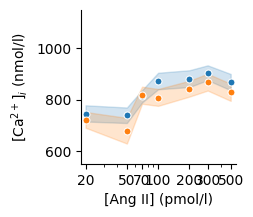

###### date and time ######
21-Apr-2023 16:22


In [16]:
# Plot Ang II dependent data (comparing genotypes)
data_plot = data_total_ang_dropped

n_animal_ang = data_total_ang_dropped.groupby(["angiotensin", "genotype"])["animal"].nunique()
n_cell_ang = data_total_ang_dropped.groupby(["angiotensin", "genotype"]).count()["cell"]

dd = pd.melt(data_plot, id_vars=["angiotensin", "potassium", "genotype"], \
             value_vars=["mean_ca_corr"], var_name="Type")    
angiotensin_konz =[20,50,70,100,200,300,500]


dd = dd[dd.value>0]
dd = dd[dd.angiotensin!=0]
dd = dd[dd.angiotensin!=10000]
dd = dd[dd.angiotensin!=1000]

dd.value = dd.value.astype(float)

x_data_ang_wt = dd.groupby(["genotype"]).get_group("wt").groupby("angiotensin").value.mean().index
y_data_ang_wt = dd.groupby(["genotype"]).get_group("wt").groupby("angiotensin").value.mean().values
#error_ang_wt = dd.groupby(["genotype"]).get_group("wt").groupby("angiotensin").value.sem().values


x_data_ang_KO = dd.groupby(["genotype"]).get_group("KO").groupby("angiotensin").value.mean().index
y_data_ang_KO = dd.groupby(["genotype"]).get_group("KO").groupby("angiotensin").value.mean().values
#error_ang_KO = dd.groupby(["genotype"]).get_group("KO").groupby("angiotensin").value.sem().values

fig1, ax1 = plt.subplots(figsize=(2,2))

sns.lineplot(x="angiotensin", y="value", hue="genotype", data=dd,\
               hue_order=["wt","KO"],
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             marker ="o",\
                   linewidth=0, ms =5, ax=ax1)

ax1.set_xscale('log')
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1.set(xticks=angiotensin_konz)
ax1.set(xticklabels=angiotensin_konz)

ax1.set(ylim=(550, 1150))
ax1.set(xlim=(18, 560))


        
#y-Achsenbeschriftung der Subplots          
#ax1.set_ylabel("[Ca$^{2+}$]$_i$ (nmol l$^{-1}$)")
ax1.set_ylabel("[Ca$^{2+}$]$_i$ (nmol/l)")

# x-Achsenbeschriftung der Subplots          
#ax1.set_xlabel("[Ang II] (pmol l$^{-1}$)")
ax1.set_xlabel("[Ang II] (pmol/l)")
 
ax1.legend_.remove()


sns.despine(top=True, right=True)
    

plt.show()
    
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

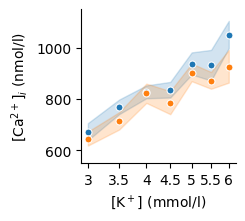

###### date and time ######
21-Apr-2023 16:22


In [17]:
# Plot K+ dependent data (comparing genotypes)
data_plot = data_total_pot_dropped

n_cell_pot =data_total_pot_dropped.groupby(["potassium", "genotype"]).count()["cell"]
n_animal_pot = data_total_pot_dropped.groupby(["potassium", "genotype"])["animal"].nunique()


dd = pd.melt(data_plot, id_vars=["angiotensin", "potassium", "genotype"], \
             value_vars=["mean_ca_corr"], var_name="Type")    
potassium_konz =[3, 3.5, 4, 4.5, 5, 5.5, 6]

dd = dd[dd.value>0]
dd.value = dd.value.astype(float)

x_data_pot_wt = dd.groupby(["genotype"]).get_group("wt").groupby("potassium").value.mean().index
y_data_pot_wt = dd.groupby(["genotype"]).get_group("wt").groupby("potassium").value.mean().values
#error_pot_wt = dd.groupby(["genotype"]).get_group("wt").groupby("potassium").value.sem().values


x_data_pot_KO = dd.groupby(["genotype"]).get_group("KO").groupby("potassium").value.mean().index
y_data_pot_KO = dd.groupby(["genotype"]).get_group("KO").groupby("potassium").value.mean().values
#error_pot_KO = dd.groupby(["genotype"]).get_group("KO").groupby("potassium").value.sem().values

fig1, ax1 = plt.subplots(figsize=(2,2))

sns.lineplot(x="potassium", y="value", hue="genotype", data=dd,\
               hue_order=["wt","KO"],
                          errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             marker ="o",\
                   linewidth=0, ms =5, ax=ax1)


ax1.set_xscale('log')
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax1.set(xticks=potassium_konz)
ax1.set(xticklabels=potassium_konz)

ax1.set(ylim=(550, 1150))
#ax1.set(xlim=(18, 560))

        
#y-Achsenbeschriftung der Subplots          
#ax1.set_ylabel("[Ca$^{2+}$]$_i$ (nmol l$^{-1}$)")
ax1.set_ylabel("[Ca$^{2+}$]$_i$ (nmol/l)")

# x-Achsenbeschriftung der Subplots          
#ax1.set_xlabel("[K$^+$] (mmol l$^{-1}$)")
ax1.set_xlabel("[K$^+$] (mmol/l)")
 
ax1.legend_.remove()


sns.despine(top=True, right=True)
    

plt.show()
    
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)